In this notebook, we performed ultrasound image segmentation using the U-Net model. We achieved an impressive accuracy of 94% and a loss of 0.0041. These results demonstrate the effectiveness of U-Net in accurately segmenting ultrasound images, indicating strong performance in our analysis.

# **1. Install packages**

In [1]:
%%capture
!pip install skorch
!pip install segmentation-models-pytorch

# **2. Load libraries**

In [2]:
# Data manipulation
#================================================================
import pandas as pd
import numpy as np

# Data visualization
#================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Data preprocessing
#==============================================================
from sklearn.model_selection import train_test_split

# Classifier
#======================================================
import torch
from torch import nn, optim
from torchvision import transforms
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from skorch.callbacks import Checkpoint
from skorch.net import NeuralNet
from skorch.helper import predefined_split

# Others
#======================================================
import os

import random

from pathlib import Path

# **3. Load data**

In [3]:
images_train_list = sorted(list(Path("/kaggle/input/fetal-head-segmentation/train_images/train_images").glob("*.png")))
masks_train_list = sorted(list(Path("/kaggle/input/fetal-head-segmentation/train_masks/train_masks").glob("*.png")))

images_test_list = sorted(list(Path("/kaggle/input/fetal-head-segmentation/test_images/val_images").glob("*.png")))
masks_test_list = sorted(list(Path("/kaggle/input/fetal-head-segmentation/test_masks/val_masks").glob("*.png")))

print(f"Total Images Train: {len(images_train_list)} | Total Masks Train: {len(masks_train_list)}")
print(f"Total Images Test: {len(images_test_list)} | Total Masks Test: {len(masks_test_list)}")

Total Images Train: 799 | Total Masks Train: 799
Total Images Test: 200 | Total Masks Test: 200


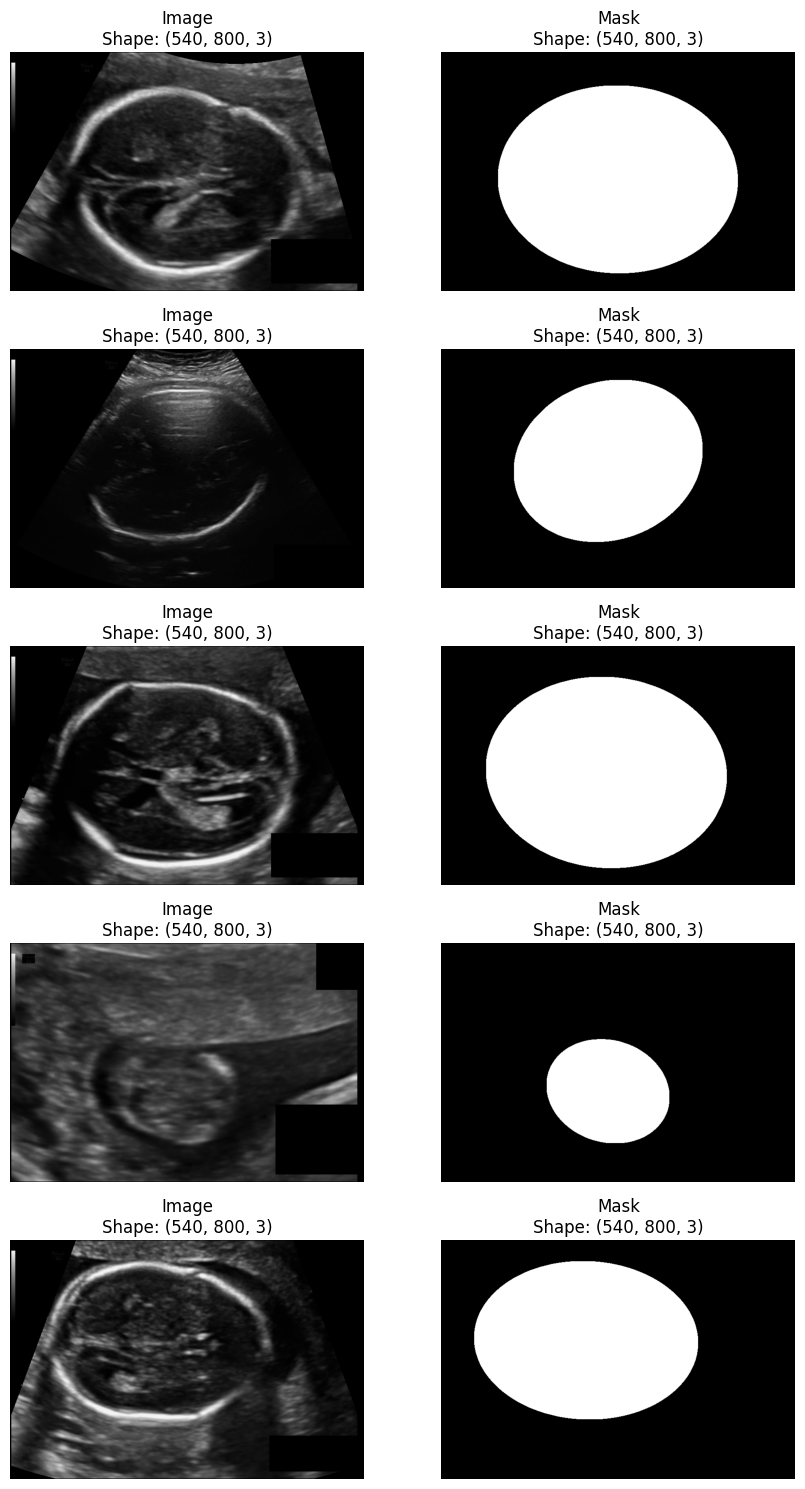

In [4]:
fig,ax = plt.subplots(nrows = 5, ncols = 2, figsize = (9, 15))

idxs = np.random.randint(low = 1, high = len(images_train_list), size = 5)

for i,idx in enumerate(idxs):
    img = cv2.imread(str(images_train_list[idx]))
    ax[i, 0].imshow(img)
    ax[i, 0].axis("off")
    ax[i, 0].set_title(f"Image\nShape: {img.shape}")
    
    mask = cv2.imread(str(masks_train_list[idx]))
    ax[i, 1].imshow(mask)
    ax[i, 1].axis("off")
    ax[i, 1].set_title(f"Mask\nShape: {mask.shape}")
    
fig.tight_layout()
fig.show()

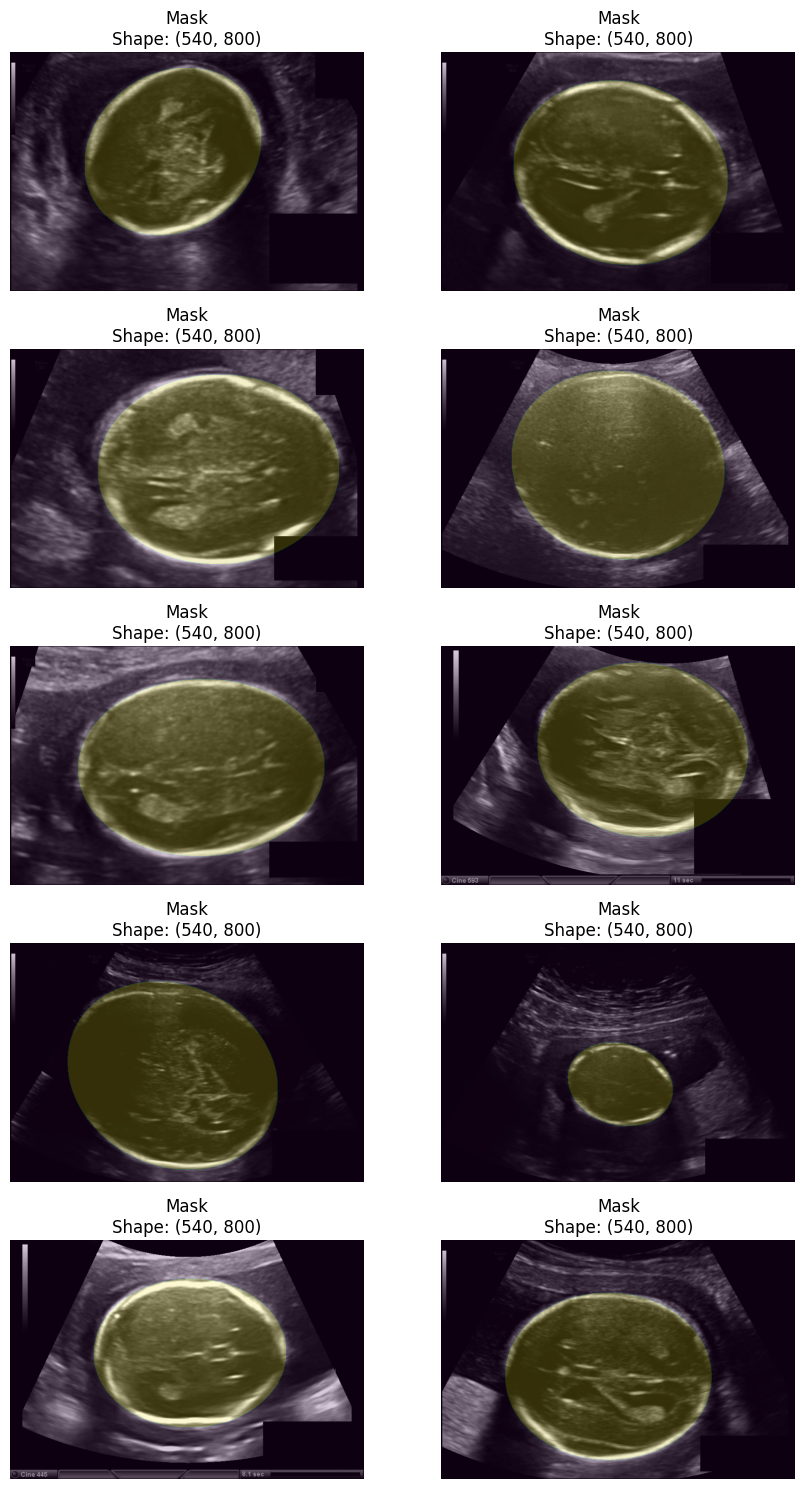

In [5]:
idxs = np.random.randint(low = 1, high = len(images_train_list), size = 10)

fig,ax = plt.subplots(nrows = 5, ncols = 2, figsize = (9, 15))
ax = ax.flat

for i,idx in enumerate(idxs):
    img = cv2.imread(str(images_train_list[idx]))
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title(f"Image\nShape: {img.shape}")
    
    mask = cv2.imread(str(masks_train_list[idx]), cv2.IMREAD_GRAYSCALE)
    ax[i].imshow(mask, alpha = 0.2)
    ax[i].axis("off")
    ax[i].set_title(f"Mask\nShape: {mask.shape}")
    
fig.tight_layout()
fig.show()

# **4. Data preprocessing**

In [6]:
data_train = pd.DataFrame({'Image': images_train_list, 
                           'Mask': masks_train_list})
data_train.head()

,Image,Mask
0,/kaggle/input/fetal-head-segmentation/train_im...,/kaggle/input/fetal-head-segmentation/train_ma...
1,/kaggle/input/fetal-head-segmentation/train_im...,/kaggle/input/fetal-head-segmentation/train_ma...
2,/kaggle/input/fetal-head-segmentation/train_im...,/kaggle/input/fetal-head-segmentation/train_ma...
3,/kaggle/input/fetal-head-segmentation/train_im...,/kaggle/input/fetal-head-segmentation/train_ma...
4,/kaggle/input/fetal-head-segmentation/train_im...,/kaggle/input/fetal-head-segmentation/train_ma...


In [7]:
SEED = 42
train_dataset, val_dataset = train_test_split(data_train, 
                                              test_size = 0.2, 
                                              random_state = SEED)

In [8]:
smp.encoders.get_preprocessing_fn("resnet34")

functools.partial(<function preprocess_input at 0x7a1bc0774820>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [9]:
RESIZE = (224, 224)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([transforms.Resize(size = RESIZE), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean = MEAN, 
                                                            std = STD)])

In [10]:
def mask_transforms(mask_path:Path):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, dsize = RESIZE)
    mask = mask.astype(np.float32)
    mask[mask > 0.] = 1
    
    return mask

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data:pd.DataFrame, image_transforms, mask_transforms):
        self.data = data
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_new = self.data.copy()
        image_path = data_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)
        
        mask_path = data_new.iloc[idx, 1]
        mask = self.mask_transforms(mask_path)
        mask = np.expand_dims(mask, axis = 0)
        return image, mask

In [12]:
train_data = CustomDataset(train_dataset, image_transforms, mask_transforms)
val_data = CustomDataset(val_dataset, image_transforms, mask_transforms)

# **5. Unet**

In [13]:
model = smp.Unet()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 216MB/s] 


In [14]:
# Now Let's visualize the architecture of our model.
summary(model = model, 
        input_size = [32, 3, 224, 224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 15, 
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
Unet (Unet)                                        [32, 3, 224, 224] [32, 1, 224, 224] --              True
├─ResNetEncoder (encoder)                          [32, 3, 224, 224] [32, 3, 224, 224] --              True
│    └─Conv2d (conv1)                              [32, 3, 224, 224] [32, 64, 112, 112] 9,408           True
│    └─BatchNorm2d (bn1)                           [32, 64, 112, 112] [32, 64, 112, 112] 128             True
│    └─ReLU (relu)                                 [32, 64, 112, 112] [32, 64, 112, 112] --              --
│    └─MaxPool2d (maxpool)                         [32, 64, 112, 112] [32, 64, 56, 56] --              --
│    └─Sequential (layer1)                         [32, 64, 56, 56] [32, 64, 56, 56] --              True
│    │    └─BasicBlock (0)                         [32, 64, 56, 56] [32, 64, 56, 56] 73,984          True
│    │    └─BasicBlock (1)    

In [15]:
from skorch.callbacks import Freezer, EpochScoring

In [16]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [17]:
summary(model = model, 
        input_size = [32, 3, 224, 224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 15, 
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
Unet (Unet)                                        [32, 3, 224, 224] [32, 1, 224, 224] --              Partial
├─ResNetEncoder (encoder)                          [32, 3, 224, 224] [32, 3, 224, 224] --              False
│    └─Conv2d (conv1)                              [32, 3, 224, 224] [32, 64, 112, 112] (9,408)         False
│    └─BatchNorm2d (bn1)                           [32, 64, 112, 112] [32, 64, 112, 112] (128)           False
│    └─ReLU (relu)                                 [32, 64, 112, 112] [32, 64, 112, 112] --              --
│    └─MaxPool2d (maxpool)                         [32, 64, 112, 112] [32, 64, 56, 56] --              --
│    └─Sequential (layer1)                         [32, 64, 56, 56] [32, 64, 56, 56] --              False
│    │    └─BasicBlock (0)                         [32, 64, 56, 56] [32, 64, 56, 56] (73,984)        False
│    │    └─BasicBlock

In [18]:
def iou_scoring(net, ds, y):
    predicted_logit_masks = net.predict(ds)
    prob_mask = torch.from_numpy(predicted_logit_masks).sigmoid()
    pred_mask = (prob_mask > 0.5).float()

    tp,fp,fn,tn = smp.metrics.get_stats(output = pred_mask.detach().cpu().long(), 
                                        target = torch.from_numpy(y).long(), 
                                        mode = "binary")

    return smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro").numpy()

In [19]:
iou_scoring = EpochScoring(iou_scoring, name='iou', lower_is_better=False)

In [20]:
net = NeuralNet(
    model,
    criterion=smp.losses.DiceLoss(mode = 'binary'),
    batch_size = 32, 
    lr = 0.001,
    max_epochs = 100,
    optimizer= optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers = 2,
    iterator_valid__shuffle = False,
    iterator_valid__num_workers = 2,
    train_split = predefined_split(val_data),
    callbacks=[
               iou_scoring,
               Checkpoint(f_params='best_params.pt')],
    device='cuda',
)

In [21]:
net.fit(train_data)

  epoch     iou    train_loss    valid_loss    cp     dur
-------  ------  ------------  ------------  ----  ------
      1  0.8178        0.3027        0.1771     +  9.7120
      2  0.8959        0.1171        0.0973     +  7.6979
      3  0.9122        0.0665        0.0663     +  7.6980
      4  0.9210        0.0487        0.0529     +  7.5757
      5  0.9259        0.0379        0.0462     +  7.8791
      6  0.9314        0.0324        0.0411     +  7.6283
      7  0.9300        0.0289        0.0404     +  7.7438
      8  0.9304        0.0269        0.0394     +  7.5842
      9  0.9275        0.0253        0.0405        7.5944
     10  0.9321        0.0244        0.0377     +  7.5447
     11  0.9267        0.0228        0.0402        7.9123
     12  0.9332        0.0218        0.0364     +  8.0240
     13  0.9304        0.0195        0.0377        8.0177
     14  0.9314        0.0179        0.0371        8.1147
     15  0.9254        0.0180        0.0401        7.7094
     16  0.925

<class 'skorch.net.NeuralNet'>[initialized](
  module_=Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [22]:
net.load_params(f_params='best_params.pt')

# **6. Metrics and display**

In [23]:
data_test = pd.DataFrame({'Image': images_test_list, 
                           'Mask': masks_test_list})
data_test.head()

,Image,Mask
0,/kaggle/input/fetal-head-segmentation/test_ima...,/kaggle/input/fetal-head-segmentation/test_mas...
1,/kaggle/input/fetal-head-segmentation/test_ima...,/kaggle/input/fetal-head-segmentation/test_mas...
2,/kaggle/input/fetal-head-segmentation/test_ima...,/kaggle/input/fetal-head-segmentation/test_mas...
3,/kaggle/input/fetal-head-segmentation/test_ima...,/kaggle/input/fetal-head-segmentation/test_mas...
4,/kaggle/input/fetal-head-segmentation/test_ima...,/kaggle/input/fetal-head-segmentation/test_mas...


In [24]:
test_data = CustomDataset(data_test, image_transforms, mask_transforms)

In [25]:
pred_mask_test = net.predict(test_data)

In [26]:
pred_mask_test_prob = torch.from_numpy(pred_mask_test.squeeze()).sigmoid()
pred_mask_test_class = (pred_mask_test_prob > 0.5).float()
pred_mask_test_class.shape

torch.Size([200, 224, 224])

In [27]:
mask_test = [mask for _, mask in DataLoader(dataset = test_data)]
mask_test = torch.cat(mask_test)
mask_test = mask_test.squeeze()
mask_test.shape

torch.Size([200, 224, 224])

In [28]:
TP, FP, FN, TN = smp.metrics.get_stats(pred_mask_test_class.long(), 
                                       mask_test.long(), 
                                       mode = "binary")

iou_test = smp.metrics.iou_score(TP, FP, FN, TN, reduction = "micro")
print(f'IOU Test = {iou_test:.4f}')

IOU Test = 0.9418


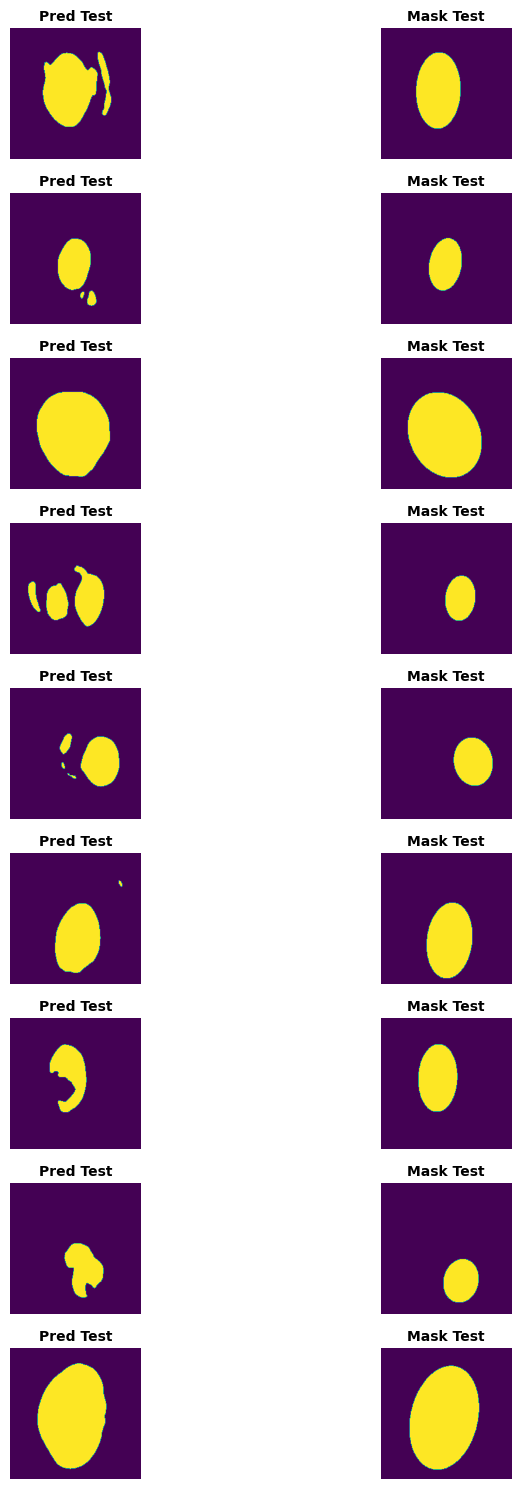

In [29]:
fig,ax = plt.subplots(nrows = 9, ncols = 2, figsize = (10, 15))

for i, (pred, mask) in enumerate(zip(pred_mask_test_class, mask_test)):
    if i >8:
        break
        
    ax[i, 0].imshow(pred)
    ax[i, 0].set_title("Pred Test", fontsize = 10, fontweight = 'bold', color = 'black')
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(mask)
    ax[i, 1].set_title("Mask Test", fontsize = 10, fontweight = 'bold', color = 'black')
    ax[i, 1].axis('off')

fig.tight_layout()
fig.show()

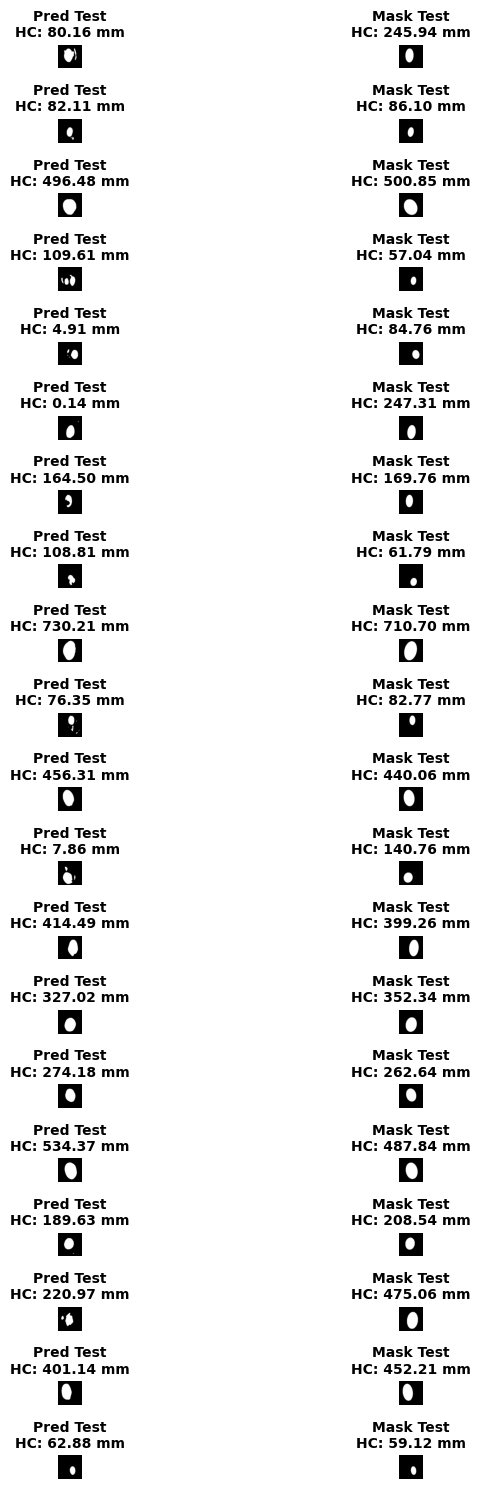

In [30]:
import skimage.filters
import skimage.measure
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate BPD and OFD
def calculate_BPD_OFD(mask):
    # Convert mask to numpy array and scale to uint8
    image_gray = np.array(mask).astype('uint8') * 255  
    
    # Apply Otsu's thresholding to get the binary mask
    thresh = skimage.filters.threshold_otsu(image_gray)
    tumor_mask = image_gray > thresh
    
    # Label connected components
    label_image = skimage.measure.label(tumor_mask)
    region_props = skimage.measure.regionprops(label_image)
    
    # Initialize BPD and OFD
    BPD = 0
    OFD = 0
    
    # Calculate BPD and OFD
    if len(region_props) > 0:
        # Assuming region_props[0] corresponds to the largest connected component
        bbox_min_row, bbox_min_col, bbox_max_row, bbox_max_col = region_props[0].bbox
        
        # Calculate BPD (distance between the widest points)
        BPD = (bbox_max_col - bbox_min_col) / 50.8
        
        # Calculate OFD (distance between the highest and lowest points)
        OFD = (bbox_max_row - bbox_min_row) / 33.866666667
    
    return BPD, OFD

# Initialize the figure and axes
fig, ax = plt.subplots(nrows=20, ncols=2, figsize=(10, 15))

# Loop over the predictions and masks
for i, (pred, mask) in enumerate(zip(pred_mask_test_class, mask_test)):
    if i > 19:
        break
    
    # Calculate BPD and OFD for the predicted mask
    BPD_pred, OFD_pred = calculate_BPD_OFD(pred)
    # Calculate the head circumference (HC) for the predicted mask
    HC_pred = 1.62 * (BPD_pred + OFD_pred) ** 3
    
    # Calculate BPD and OFD for the normal mask
    BPD_mask, OFD_mask = calculate_BPD_OFD(mask)
    # Calculate the head circumference (HC) for the normal mask
    HC_mask = 1.62 * (BPD_mask + OFD_mask) ** 3
    
    # Plot the predicted mask
    ax[i, 0].imshow(pred, cmap='gray')
    ax[i, 0].set_title(f"Pred Test\nHC: {HC_pred:.2f} mm", fontsize=10, fontweight='bold', color='black')
    ax[i, 0].axis('off')
    
    # Plot the normal mask
    ax[i, 1].imshow(mask, cmap='gray')
    ax[i, 1].set_title(f"Mask Test\nHC: {HC_mask:.2f} mm", fontsize=10, fontweight='bold', color='black')
    ax[i, 1].axis('off')

# Adjust layout
fig.tight_layout()
plt.show()


In [31]:
import os

# Specify the directory
directory_path = '/kaggle/working/'

# List files and directories in the specified directory
files_and_dirs = os.listdir(directory_path)

print("Files and directories in '", directory_path, "':")
for item in files_and_dirs:
    print(item)


Files and directories in ' /kaggle/working/ ':
optimizer.pt
best_params.pt
history.json
.virtual_documents
criterion.pt


In [32]:
import pickle 
pytorch_model = torch.load('/kaggle/working/best_params.pt')

outfile = "UNET.pkl"

with open(outfile, 'wb') as pickle_file:
    pickle.dump(pytorch_model, pickle_file)